$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 5: Control a Marble with Reinforcement Learning

Jared Zymbaluk

## Overview

In this assignment, you will be modifying the reinforcement learning code used to solve the dynamic marble problem.  You will be solving a more complex version of the marble problem in which a goal position is specified as a new state variable.

Start with the code in the notebook for lecture notes 24, and the associated neural network and mlutilities that you can download in [this tar file](http://www.cs.colostate.edu/~anderson/cs445/notebooks/A5.tar).


## Requirements

Modify the code from Lecture Notes 24 to change the
reinforcement learning problem to one for which the goal position of
the marble can be varied. In other words, your new code must train one Q network for the marble problem with a variable goal. 

Use the plotting code from Lecture 24 to show your results.  In addition to those plots, create nine additional versions of the lower-right plot for goal positions at 1, 2, 3, 4, 5, 6, 7, 8, and 9.

The general approach is as follows.

The state of the marble is given by $(x_t,
\dot{x_t})$.  In this new problem, the state will be $(x_t,
\dot{x_t}, g_t)$, where $g_t$ is the goal at time $t$.  Modify the
`initialState` function to randomly choose a new goal $g_t$ to be a
random value between 1 and 9. Modify `nextState` so that the goal
value remains the same in the new state as it was in the old state.  You will also
have to parameterize the reinforcement function to depend on the
current $g_t$ value.

Many of the figures will still make sense.  Include them in your
report.  The contour (and surface)
plots and the plot that tests the marble's behavior for various intial
positions must be produced for a single value of the goal.  Generate
several versions of the contour and surface plots and the test plots for goals of 1, 5, and 9 to show how
they vary when the goal is varied.

Experiment with values of the parameters, such as the number of trials, number of
steps per trial, number of SCG iterations in each train call, number of hidden units, finalEpsilon, and gamma.  Try
to find values that result in a trained network that controls the
marble well for most of the goal settings.
Discuss your experience with finding good parameter values.

Discuss the changes you tried and the results.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import neuralnetworksA4 as nn
import random

In [86]:
from copy import copy

actions = (-1, 0, 1)   # Possible actions

def reinforcement(s,s1):
    goal = s[2]
    # return 0 if abs(s1[0]-goal) < 1 else -1
    return -abs(s1[0] - goal)

def initialState():
    num = random.randint(1,10)
    return np.array([10*np.random.random_sample(), 0.0,num])

def nextState(s,a):
    s = copy(s)   # s[0] is position, s[1] is velocity. a is -1, 0 or 1
    deltaT = 0.1                           # Euler integration time step
    s[0] += deltaT * s[1]                  # Update position
    s[1] += deltaT * (2 * a - 0.2 * s[1])  # Update velocity. Includes friction
    if s[0] < 0:        # Bound next position. If at limits, set velocity to 0.
        s = [0,0,s[2]]
    elif s[0] > 10:
        s = [10,0,s[2]]
    return s

In [87]:
def epsilonGreedy(nnetQ, state, actions, epsilon):
    if np.random.uniform() < epsilon:
        # Random Move
        action = np.random.choice(actions)
    else:
        # Greedy Move
        Qs = [nnetQ.use(np.hstack((state[:2],a)).reshape((1, -1))) for a in actions]
        ai = np.argmax(Qs)
        action = actions[ai]
    Q = nnetQ.use(np.hstack((state[:2],action)).reshape((1, -1)))
    return action, Q

In [93]:
def makeSamples(nnet, initialStateF, nextStateF, reinforcementF,
                validActions, numSamples, epsilon):

    X = np.zeros((numSamples, nnet.ni))
    R = np.zeros((numSamples, 1))
    Qn = np.zeros((numSamples, 1))

    s = initialStateF()
    s = nextStateF(s, 0)        # Update state, sn from s and a
    a, _ = epsilonGreedy(nnet, s, validActions, epsilon)

    # Collect data from numSamples steps
    for step in range(numSamples):
        sn = nextStateF(s, a)        # Update state, sn from s and a
        rn = reinforcementF(s, sn)   # Calculate resulting reinforcement
        an, qn = epsilonGreedy(nnet, sn, validActions, epsilon) # Forward pass for time t+1
        X[step, :] = np.hstack((s[:2],a))
        R[step, 0] = rn
        Qn[step, 0] = qn
        # Advance one time step
        s, a = sn, an

    return (X, R, Qn)

In [94]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def plotStatus(net,trial,epsilonTrace,rtrace):
    plt.subplot(4,3,1)
    plt.plot(epsilonTrace[:trial+1])
    plt.ylabel("Random Action Probability ($\epsilon$)")
    plt.ylim(0,1)
    plt.subplot(4,3,2)
    plt.plot(X[:,0])
    plt.plot([0,X.shape[0]], [5,5],'--',alpha=0.5,lw=5)
    plt.ylabel("$x$")
    plt.ylim(-1,11)
    #qs = [[net.use([s,0,a]) for a in actions] for s in range(11)]
    qs = net.use(np.array([[s,0,a] for a in actions for s in range(11)]))
    #print np.hstack((qs,-1+np.argmax(qs,axis=1).reshape((-1,1))))
    plt.subplot(4,3,3)
    acts = ["L","0","R"]
    actsiByState = np.argmax(qs.reshape((len(actions),-1)),axis=0)
    for i in range(11):
        plt.text(i,0,acts[actsiByState[i]])
        plt.xlim(-1,11)
        plt.ylim(-1,1)
    plt.text(2,0.2,"Policy for Zero Velocity")
    plt.axis("off")
    plt.subplot(4,3,4)
    plt.plot(rtrace[:trial+1],alpha=0.5)
    #plt.plot(np.convolve(rtrace[:trial+1],np.array([0.02]*50),mode='valid'))
    binSize = 20
    if trial+1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(rtrace[:int(trial/binSize)*binSize].reshape((int(trial/binSize),binSize)),axis=1)
        plt.plot(np.arange(1,1+int(trial/binSize))*binSize,smoothed)
    plt.ylabel("Mean reinforcement")
    plt.subplot(4,3,5)
    plt.plot(X[:,0],X[:,1])
    plt.plot(X[0,0],X[0,1],'o')
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.fill_between([4,6],[-5,-5],[5,5],color="red",alpha=0.3)
    plt.xlim(-1,11)
    plt.ylim(-5,5)
    plt.subplot(4,3,6)
    net.draw(["$x$","$\dot{x}$","$a$"],["Q"])
    
    plt.subplot(4,3,7)
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    #states = np.vstack((xs.flat,ys.flat)).T
    #qs = [net.use(np.hstack((states,np.ones((states.shape[0],1))*act))) for act in actions]
    xsflat = xs.flat
    ysflat = ys.flat
    qs = net.use(np.array([[xsflat[i],ysflat[i],a] for a in actions for i in range(len(xsflat))]))
    #qs = np.array(qs).squeeze().T
    qs = qs.reshape((len(actions),-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax)
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Max Q")
    plt.subplot(4,3,8)
    acts = np.array(actions)[np.argmax(qs,axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs,ys,acts,[-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Actions")
    
    s = plt.subplot(4,3,10)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,qsmax,cstride=1,rstride=1,cmap=cm.jet,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Max Q")
    plt.title("Max Q")
    
    s = plt.subplot(4,3,11)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,acts,cstride=1,rstride=1,cmap=cm.jet,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Action")
    plt.title("Action")
    
    plt.tight_layout()

In [148]:
def testIt(Qnet,nTrials,nStepsPerTrial,g):
    xs = np.linspace(0,10,nTrials)
    #plt.subplot(4,3,12)
    #plt.subplot(3,3,g)
    plt.figure(g)
    for x in xs:
        s = [x,0,g] ## 0 velocity
        xtrace = np.zeros((nStepsPerTrial,2))
        for step in range(nStepsPerTrial):
            a,_ = epsilonGreedy(Qnet,s,actions,0.0) # epsilon = 0
            s = nextState(s,a)
            xtrace[step,:] = s[:2]
        plt.plot(xtrace[:,0],xtrace[:,1])
        plt.xlim(-1,11)
        plt.ylim(-5,5)
        plt.plot([g,g],[-g,g],'--',alpha=0.5,lw=5)
        plt.ylabel('$\dot{x}$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$, goal ='+ str(g))

In [138]:
def setupStandardization(net, Xmeans, Xstds, Tmeans, Tstds):
    net.Xmeans = Xmeans
    net.XstdsFixed = Xstds
    net.Xconstant = [False] * len(Xmeans)
    net.TstdsFixed = net.Tstds = Tstds
    net.Tmeans = Tmeans
    net.Tconstant = [False] * len(Tstds)

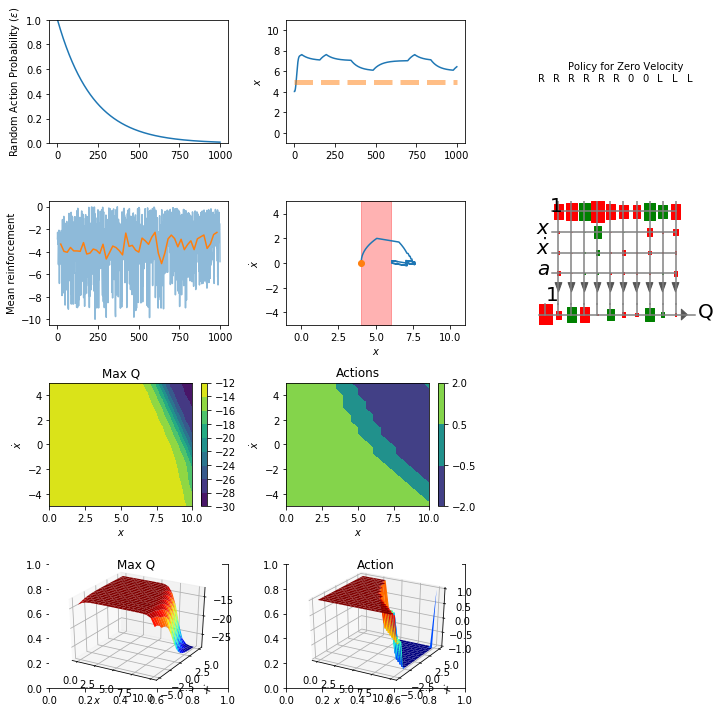

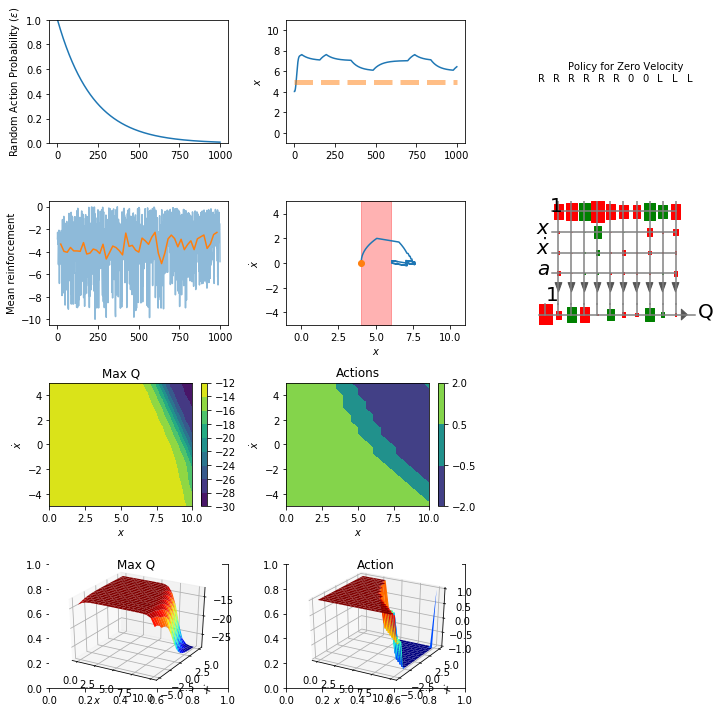

In [143]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10,10))

gamma = 0.8        # discount factor
nTrials = 1000        # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4  # maximum number of SCG iterations
finalEpsilon = 0.01 # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon)/(nTrials)) # to produce this final value
print("epsilonDecay is",epsilonDecay)

nh = 10           # number of hidden units
nnetQ = nn.NeuralNetwork(3, nh, 1)  # ((0,10),(-3,3),(-1,1)))
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 0], [2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    X, R, Qn = makeSamples(nnetQ,  initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
    nnetQ.train(X, R + gamma*Qn, nIterations=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial+1 == nTrials or trial % (nTrials/40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        #testIt(nnetQ, 10, 500,i+1)
        clear_output(wait=True)
        display(fig)
    
#clear_output(wait=True)

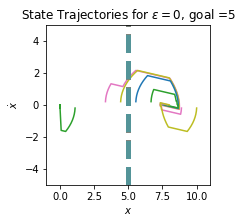

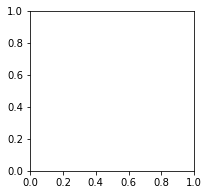

In [174]:
from IPython.display import display, clear_output
fig1 = plt.figure(num=1, figsize=(10,10))
fig2 = plt.figure(num=2, figsize=(10,10))
fig3 = plt.figure(num=3, figsize=(10,10))
fig4 = plt.figure(num=4, figsize=(10,10))
fig5 = plt.figure(num=5, figsize=(10,10))
fig6 = plt.figure(num=6, figsize=(10,10))
fig7 = plt.figure(num=7, figsize=(10,10))
fig8 = plt.figure(num=8, figsize=(10,10))
fig9 = plt.figure(num=9, figsize=(10,10))
figlist = [fig1,fig2,fig3,fig4,fig5,fig6,fig7,fig8,fig9]


gamma = 0.8        # discount factor
nTrials = 1000        # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4  # maximum number of SCG iterations
finalEpsilon = 0.01 # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon)/(nTrials)) # to produce this final value
print("epsilonDecay is",epsilonDecay)

nh = 10           # number of hidden units
nnetQ = nn.NeuralNetwork(3, nh, 1)  # ((0,10),(-3,3),(-1,1)))
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 0], [2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for i in range(1):
    for trial in range(nTrials):
        # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
        X, R, Qn = makeSamples(nnetQ,  initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
        nnetQ.train(X, R + gamma*Qn, nIterations=nSCGIterations)

        # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
        # Rest is for plotting
        epsilonTrace[trial] = epsilon
        epsilon *= epsilonDecay
        rtrace[trial] = np.mean(R)
        if True and (trial+1 == nTrials or trial % (nTrials/40) == 0):
#            plt.subplot(3,3,5)
            figlist[4].clf()
            #plotStatus(nnetQ, trial, epsilonTrace, rtrace)
            testIt(nnetQ, 10, 500,5)
            clear_output(wait=True)
            


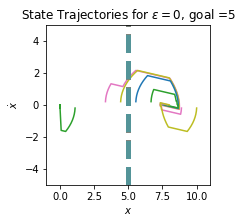

In [176]:
display(fig5)

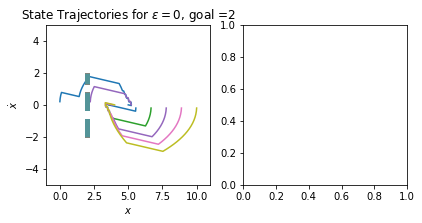

In [166]:
display(fig2)

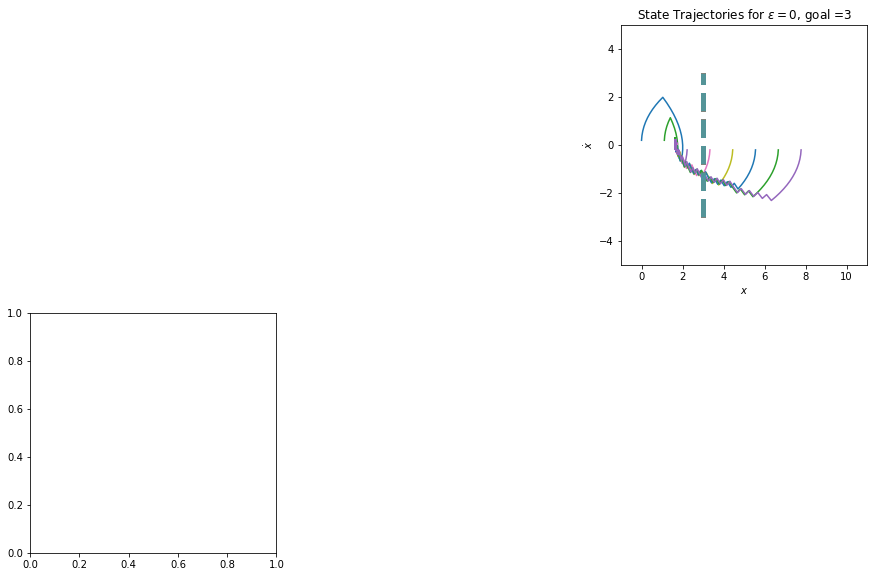

In [167]:
display(fig3)

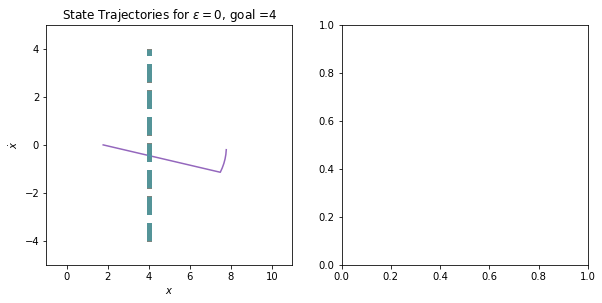

In [169]:
display(fig4)

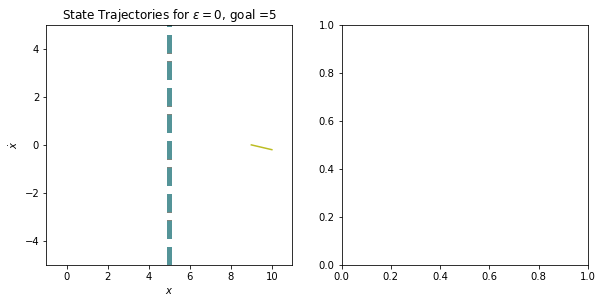

In [170]:
display(fig5)

## Grading

There is no automatic grading code for this notebook.  Do your best to show code and results you used to find good parameter values, to train your successful Q network, and to demonstrate that it is successful.

Include text to explain what you did, how successful it was, and any problems you encountered.

## Extra Credit

One point of extra credit will be given for completing each of the following things.

* Change the marble's world from one dimension to two. Add graphs of the marble's movement in the two-dimensional plane.
* Increase the number of valid actions from three to seven and discuss the difference between the required runs and these new runs.
* Add a variable wind as a force on the marble, along with another state variable that indicates wind speed and direction.
* Add a second marble with its own RL agent.  Add negative reinforcement if they bump into each other.
* Add areas of increased friction to the track.

For all of these, demonstrate the effects and write about what you observe.  Full extra credit points will only be awarded if you clearly describe your work and results for each point.

## Check-in

Do not include this section in your notebook.

Name your notebook ```Lastname-A5.ipynb```.  So, for me it would be ```Anderson-A5.ipynb```.  Submit the file using the ```Assignment 5``` link on [Canvas](https://colostate.instructure.com/courses/41327).
